# Predict the Mean Cost of a discharge using:
1.Facility Name
2.APR DRG Code
3.APR Severity of Illness Description
4.APR Medical Surgical Description


## Imports

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


## Information about/ Setting up the dataset.

In [2]:
file_src = "../data/raw/Hospital_Inpatient_Discharges__SPARCS_De-Identified___Cost_Transparency__Beginning_2009_20250426.csv"
raw_health_data = pd.read_csv(file_src)
raw_health_data

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,"8,375.41","8,375.41","3,585.05","3,585.05"
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,"14,029.82","12,176.95","6,182.67","5,253.15"
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,"23,921.77","20,229.81","11,149.49","9,068.10"
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,"51,260.45","35,210.82","26,081.70","15,230.62"
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,"25,357.84","25,357.84","7,791.75","7,791.75"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192822,2021,10355,David H. Koch Center For Cancer Care,950,1,EXTENSIVE O.R. PROCEDURE UNRELATED TO PRINCIPA...,Minor,P,Surgical,10,"75,459.38","80,267.15","32,054.83","34,156.67"
1192823,2021,10355,David H. Koch Center For Cancer Care,950,2,EXTENSIVE O.R. PROCEDURE UNRELATED TO PRINCIPA...,Moderate,P,Surgical,7,"89,203.26","99,430.57","37,249.02","43,237.60"
1192824,2021,10355,David H. Koch Center For Cancer Care,950,3,EXTENSIVE O.R. PROCEDURE UNRELATED TO PRINCIPA...,Major,P,Surgical,1,"144,762.54","144,762.54","58,875.36","58,875.36"
1192825,2021,10355,David H. Koch Center For Cancer Care,951,2,MODERATELY EXTENSIVE O.R. PROCEDURE UNRELATED ...,Moderate,P,Surgical,2,"17,505.48","17,505.48","7,181.56","7,181.56"


In [27]:
# Dataset Information
print(raw_health_data.info())

print(raw_health_data.shape) 




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192827 entries, 0 to 1192826
Data columns (total 14 columns):
 #   Column                               Non-Null Count    Dtype 
---  ------                               --------------    ----- 
 0   Year                                 1192827 non-null  int64 
 1   Facility Id                          1192827 non-null  int64 
 2   Facility Name                        1192827 non-null  object
 3   APR DRG Code                         1192827 non-null  int64 
 4   APR Severity of Illness Code         1192827 non-null  int64 
 5   APR DRG Description                  1192827 non-null  object
 6   APR Severity of Illness Description  1192617 non-null  object
 7   APR Medical Surgical Code            1192348 non-null  object
 8   APR Medical Surgical Description     1192827 non-null  object
 9   Discharges                           1192827 non-null  object
 10  Mean Charge                          1192827 non-null  object
 11  Median Char

## Setting Graph Themes

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Pre Processing

In [33]:
# Check for Missing Values
print(raw_health_data.isnull().sum())

# Used to see if there is are missing years
print(sorted(set(range(2009,2022)) - set(raw_health_data["Year"].unique())))

# Keep only relevant columns to the analysis
relevant_columns = ['Year','Facility Name', 'APR DRG Code', 'APR Severity of Illness Description', 'APR Medical Surgical Description','Discharges','Mean Cost']

cleaned_health_data = raw_health_data[relevant_columns]

# Convert Mean Cost and Discharges into Numbers
cleaned_health_data['Discharges'] = pd.to_numeric(cleaned_health_data['Discharges'], errors='coerce')
cleaned_health_data['Mean Cost'] = pd.to_numeric(cleaned_health_data['Mean Cost'].replace({'\\$': '', ',': ''}, regex=True), errors='coerce')

# Removing any Nan Values
cleaned_health_data = cleaned_health_data.dropna()

cleaned_health_data





Year                                     0
Facility Id                              0
Facility Name                            0
APR DRG Code                             0
APR Severity of Illness Code             0
APR DRG Description                      0
APR Severity of Illness Description    210
APR Medical Surgical Code              479
APR Medical Surgical Description         0
Discharges                               0
Mean Charge                              0
Median Charge                            0
Mean Cost                                0
Median Cost                              0
dtype: int64
[2018, 2019, 2020]


,Year,Facility Name,APR DRG Code,APR Severity of Illness Description,APR Medical Surgical Description,Discharges,Mean Cost
0,2016,Albany Memorial Hospital,194,Minor,Medical,2.0,3585.05
1,2016,Albany Memorial Hospital,194,Moderate,Medical,40.0,6182.67
2,2016,Albany Memorial Hospital,194,Major,Medical,70.0,11149.49
3,2016,Albany Memorial Hospital,194,Extreme,Medical,12.0,26081.70
4,2016,Albany Memorial Hospital,196,Extreme,Medical,1.0,7791.75
...,...,...,...,...,...,...,...
1192822,2021,David H. Koch Center For Cancer Care,950,Minor,Surgical,10.0,32054.83
1192823,2021,David H. Koch Center For Cancer Care,950,Moderate,Surgical,7.0,37249.02
1192824,2021,David H. Koch Center For Cancer Care,950,Major,Surgical,1.0,58875.36
1192825,2021,David H. Koch Center For Cancer Care,951,Moderate,Surgical,2.0,7181.56


## Cleaned Dataset Information

In [34]:
print("Dataset Info:")
print(cleaned_health_data.info())
print("\nFirst 5 Rows:")
print(cleaned_health_data.head())
print("\nDescribe Numeric Columns:")
print(cleaned_health_data.describe())
print("\Data Types:")
print(cleaned_health_data.dtypes)

# Variable Summaries:
print("\nFacility Name Counts:")
print(cleaned_health_data['Facility Name'].value_counts())
print("\nAPR DRG Description Counts:")
print(cleaned_health_data['APR DRG Code'].value_counts())
print("\nSeverity of Illness Description Counts:")
print(cleaned_health_data['APR Severity of Illness Description'].value_counts())

print("\nDischarges Summary:")
print(cleaned_health_data['Discharges'].describe())
print("\nMean Cost Summary:")
print(cleaned_health_data['Mean Cost'].describe())




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1191369 entries, 0 to 1192826
Data columns (total 7 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Year                                 1191369 non-null  int64  
 1   Facility Name                        1191369 non-null  object 
 2   APR DRG Code                         1191369 non-null  int64  
 3   APR Severity of Illness Description  1191369 non-null  object 
 4   APR Medical Surgical Description     1191369 non-null  object 
 5   Discharges                           1191369 non-null  float64
 6   Mean Cost                            1191369 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 72.7+ MB
None

First 5 Rows:
   Year             Facility Name  APR DRG Code  \
0  2016  Albany Memorial Hospital           194   
1  2016  Albany Memorial Hospital           194   
2  2016  Albany Memorial Hospit

## Adding Label Encoding, Outliers and Obtaining Training Data

In [9]:

label_encoders = {}

categorical_columns = ['Facility Name', 'APR DRG Code', 'APR Severity of Illness Description', 'APR Medical Surgical Description']


for col in categorical_columns:
    le = LabelEncoder()
    cleaned_health_data[col] = le.fit_transform(cleaned_health_data[col])
    label_encoders[col] = le  # Save encoders for later use (important for production!)


# feature Matrix X and Target Y
    
X = cleaned_health_data.drop('Mean Cost', axis=1)
y = cleaned_health_data['Mean Cost']

# Handling outliers
q_high = cleaned_health_data['Mean Cost'].quantile(0.99)
cleaned_health_data = cleaned_health_data[cleaned_health_data['Mean Cost'] <= q_high]

X = cleaned_health_data.drop('Mean Cost', axis=1)
y = cleaned_health_data['Mean Cost']

# Split the Data so that we can move on to the next set of steps

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Training set shape: (943564, 6)
Testing set shape: (235891, 6)


## Exploratory Data Analysis

Basic Trend Analysis

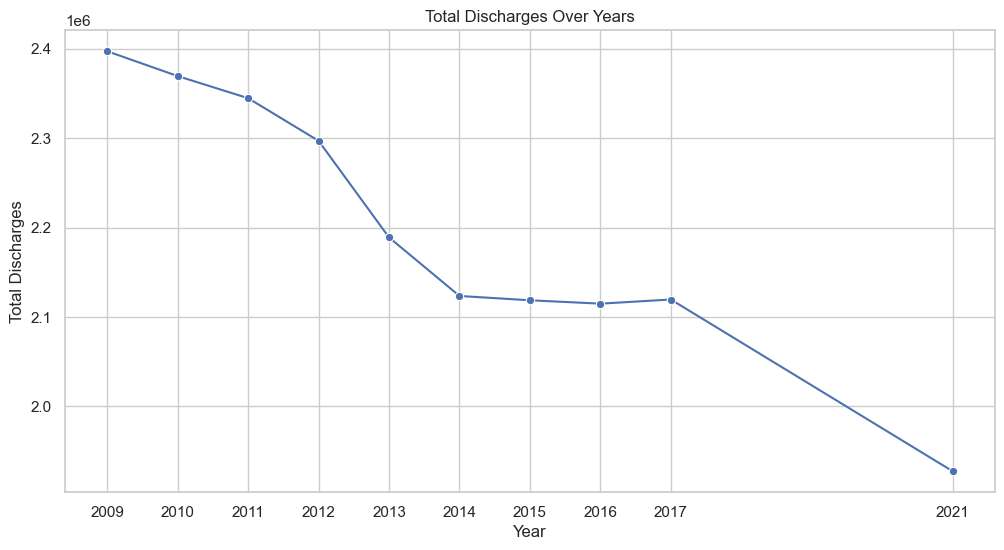

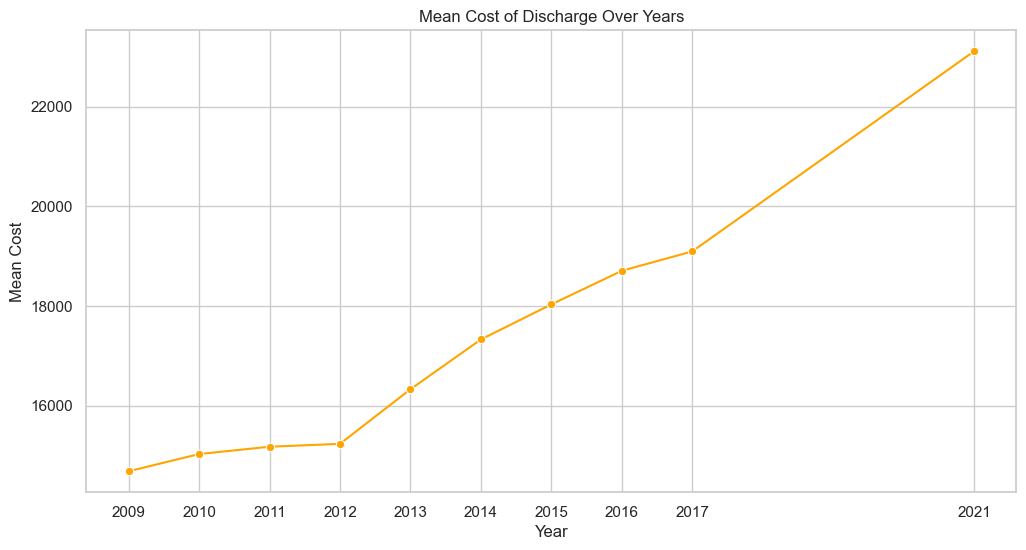

In [11]:
# Discharges by Year
discharges_by_year = cleaned_health_data.groupby('Year')['Discharges'].sum().reset_index()

sns.lineplot(data=discharges_by_year, x='Year', y='Discharges', marker="o")
plt.title("Total Discharges Over Years")
plt.xlabel("Year")
plt.ylabel("Total Discharges")
plt.xticks(discharges_by_year['Year'])
plt.show()

# Mean Cost by Year
cost_by_year = cleaned_health_data.groupby('Year')['Mean Cost'].mean().reset_index()

sns.lineplot(data=cost_by_year, x='Year', y='Mean Cost', marker="o", color="orange")
plt.title("Mean Cost of Discharge Over Years")
plt.xlabel("Year")
plt.ylabel("Mean Cost")
plt.xticks(cost_by_year['Year'])
plt.show()


Hospital and Severity Analysis

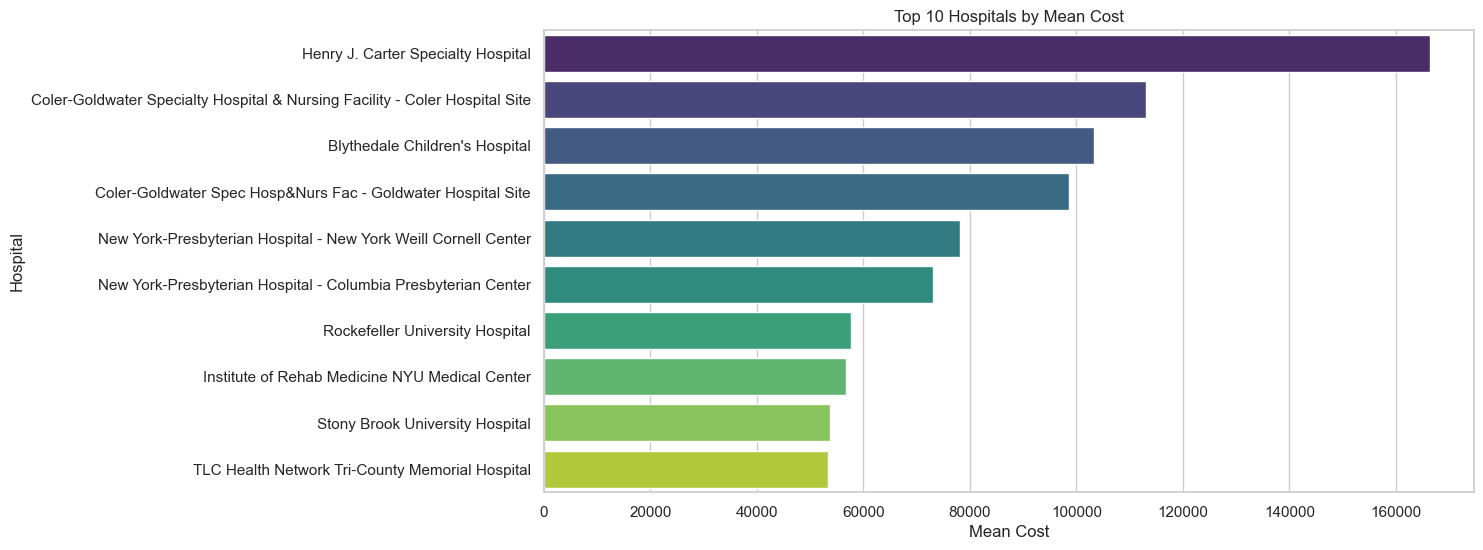

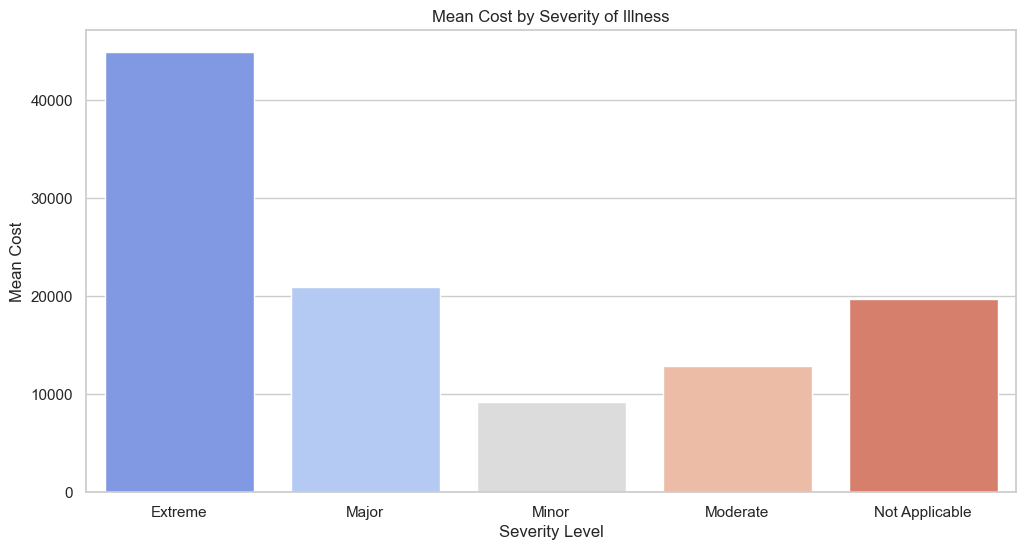

In [35]:
# Mean Cost per Hospital (Top 10 hospitals)
top_hospitals = cleaned_health_data.groupby('Facility Name')['Mean Cost'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=top_hospitals.values, y=top_hospitals.index, palette='viridis')
plt.title("Top 10 Hospitals by Mean Cost")
plt.xlabel("Mean Cost")
plt.ylabel("Hospital")
plt.show()

# Severity of Illness vs Mean Cost
severity_cost = cleaned_health_data.groupby('APR Severity of Illness Description')['Mean Cost'].mean().reset_index()

sns.barplot(data=severity_cost, x='APR Severity of Illness Description', y='Mean Cost', palette='coolwarm')
plt.title("Mean Cost by Severity of Illness")
plt.xlabel("Severity Level")
plt.ylabel("Mean Cost")
plt.show()


Distribution

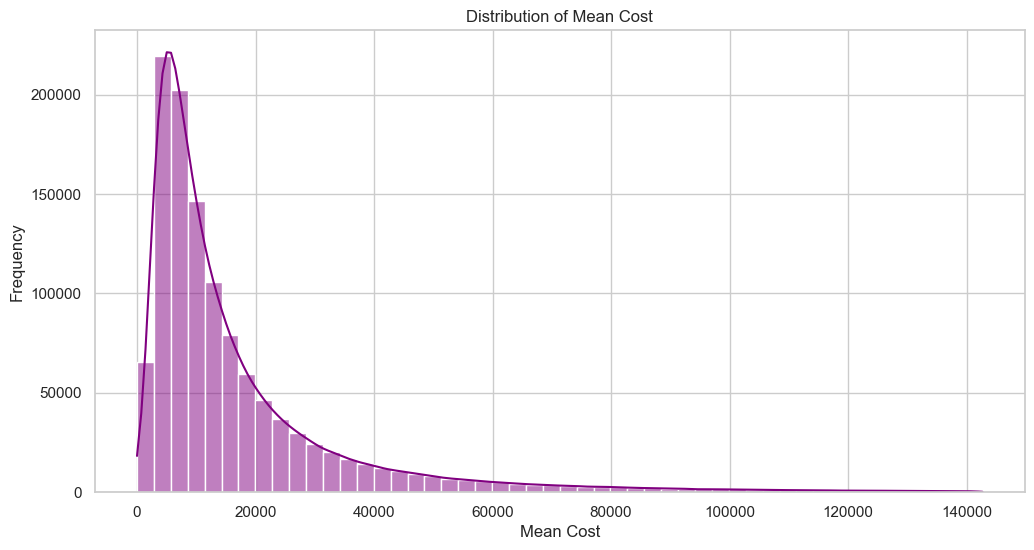

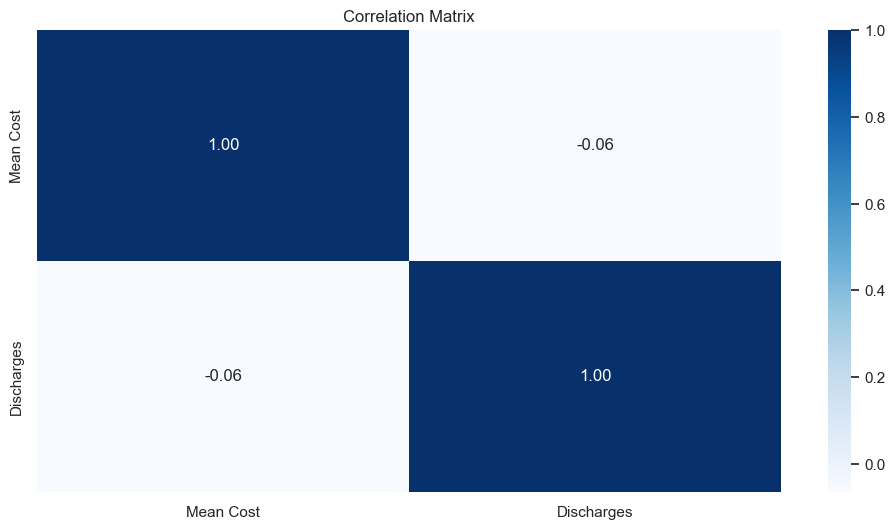

In [13]:
# Distribution of Mean Cost
sns.histplot(cleaned_health_data['Mean Cost'], bins=50, kde=True, color='purple')
plt.title("Distribution of Mean Cost")
plt.xlabel("Mean Cost")
plt.ylabel("Frequency")
plt.show()


/var/folders/_g/pjr94k1s0hg238882lwt4vj40000gn/T/ipykernel_89109/2569430288.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_health_data, x='APR Severity of Illness Description', y='Mean Cost', palette="pastel")


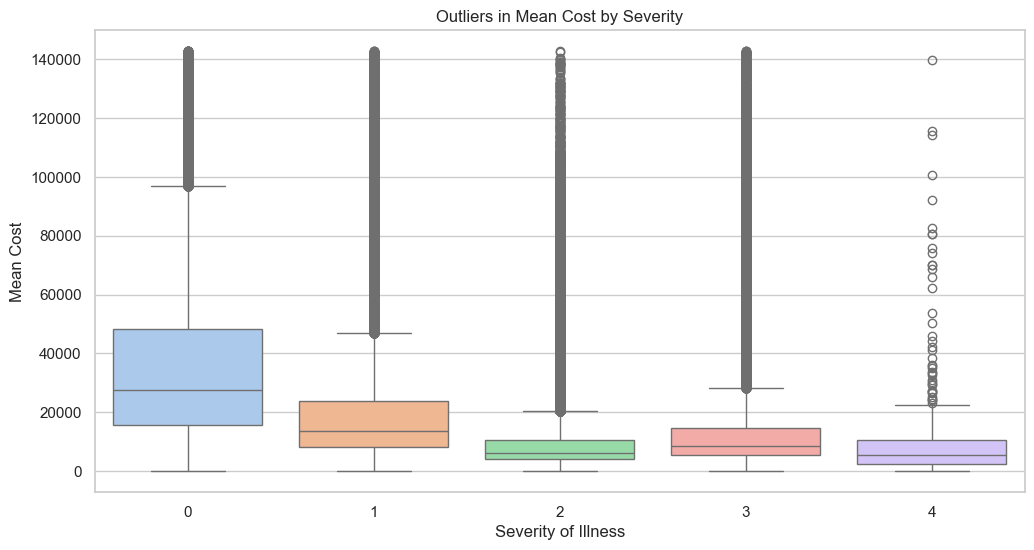

In [14]:
sns.boxplot(data=cleaned_health_data, x='APR Severity of Illness Description', y='Mean Cost', palette="pastel")
plt.title("Outliers in Mean Cost by Severity")
plt.xlabel("Severity of Illness")
plt.ylabel("Mean Cost")
plt.show()


In [15]:
print(cleaned_health_data.dtypes)


Year                                     int64
Facility Name                            int64
APR DRG Code                             int64
APR Severity of Illness Description      int64
APR Medical Surgical Description         int64
Discharges                             float64
Mean Cost                              float64
dtype: object


## Feature Engineering

In [21]:
# Initialize all models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = {
    'Linear Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgboost_model
}

# Initialize results list
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'R2_Score': r2
    })

# Turn into a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2_Score', ascending=False)

print(results_df)


               Model           MAE          RMSE           MSE  R2_Score
3            XGBoost   6335.867611  11483.176318  1.318633e+08  0.646282
2      Random Forest   6347.472084  11798.498488  1.392046e+08  0.626590
1      Decision Tree   8271.755889  15748.674077  2.480207e+08  0.334695
0  Linear Regression  10624.810625  16555.232105  2.740757e+08  0.264804


## Finetuning and Evaluation

In [22]:
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize all models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = {
    'Linear Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgboost_model
}

# Define the objective functions for each model using Optuna
def objective_lr(trial):
    # Linear Regression doesn't require hyperparameter tuning, so this is just a placeholder
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_dt(trial):
    # Hyperparameters for DecisionTreeRegressor
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = DecisionTreeRegressor(max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, 
                                  random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_rf(trial):
    # Hyperparameters for RandomForestRegressor
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestRegressor(n_estimators=n_estimators, 
                                  max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, 
                                  random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_xgb(trial):
    # Hyperparameters for XGBoost
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.7, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    model = xgb.XGBRegressor(learning_rate=learning_rate, 
                             max_depth=max_depth, 
                             min_child_weight=min_child_weight, 
                             subsample=subsample, 
                             colsample_bytree=colsample_bytree, 
                             n_estimators=n_estimators, 
                             objective='reg:squarederror', 
                             random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Initialize results list for storing the results
results = []

# Optimize each model using Optuna
for name, model in models.items():
    if name == 'Linear Regression':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_lr, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    elif name == 'Decision Tree':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_dt, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    elif name == 'Random Forest':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_rf, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    elif name == 'XGBoost':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_xgb, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    
    # Use the best hyperparameters to retrain the model
    if name == 'Linear Regression':
        model = LinearRegression()  # Linear Regression doesn't need parameters, so skip tuning.
    elif name == 'Decision Tree':
        model = DecisionTreeRegressor(**best_params, random_state=42)
    elif name == 'Random Forest':
        model = RandomForestRegressor(**best_params, random_state=42)
    elif name == 'XGBoost':
        model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'R2_Score': r2,
        'Best Params': best_params
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2_Score', ascending=False)

print(results_df)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-26 14:52:12,918] A new study created in memory with name: no-name-e3f5fe7c-a66c-4f98-a171-760697e1850b
[I 2025-04-26 14:52:13,045] Trial 0 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 14:52:13,130] Trial 1 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 14:52:13,215] Trial 2 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 14:52:13,303] Trial 3 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 14:52:13,415] Trial

               Model           MAE          RMSE           MSE  R2_Score  \
3            XGBoost   6221.482938  11381.832583  1.295461e+08  0.652498   
2      Random Forest   7687.740612  13067.912009  1.707703e+08  0.541916   
1      Decision Tree   7984.282181  13461.285396  1.812062e+08  0.513922   
0  Linear Regression  10624.810625  16555.232105  2.740757e+08  0.264804   

                                         Best Params  
3  {'learning_rate': 0.044224048131343695, 'max_d...  
2  {'n_estimators': 108, 'max_depth': 10, 'min_sa...  
1  {'max_depth': 9, 'min_samples_split': 7, 'min_...  
0                                                 {}  


In [24]:
results_df

,Model,MAE,RMSE,MSE,R2_Score,Best Params
3,XGBoost,6221.482938,11381.832583,1.295461e+08,0.652498,"{'learning_rate': 0.044224048131343695, 'max_d..."
2,Random Forest,7687.740612,13067.912009,1.707703e+08,0.541916,"{'n_estimators': 108, 'max_depth': 10, 'min_sa..."
1,Decision Tree,7984.282181,13461.285396,1.812062e+08,0.513922,"{'max_depth': 9, 'min_samples_split': 7, 'min_..."
0,Linear Regression,10624.810625,16555.232105,2.740757e+08,0.264804,{}
